## Advanced Lane Finding Notebook ##
This project calibrates images from a vehicles central camera for use in detecting lanes.

### Imports and Constants ###

In [1]:
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import operator
import random
%matplotlib inline

M_PER_PIXEL_y = 30/720 # meters per pixel in y dimension
M_PER_PIXEL_x = 3.7/700 # meters per pixel in x dimension
PIXEL_PER_M_y = 720/30
PIXEL_PER_M_x = 700/3.7


### Display Functions ###

In [12]:
def plotOne(img1, title1, cmap1=None):
    plt.imshow(img1, cmap=cmap1)
    plt.title(title1)
    plt.show()
    return

def plotMany(nrows, ncols, images, titles, cmaps):
    f, axes = plt.subplots(nrows, ncols, figsize=(16, 9))
    if nrows == 1 or ncols == 1:
        for idx, img in enumerate(images):
            axes[idx].imshow(img, cmap=cmaps[idx])
            axes[idx].set_title(titles[idx], fontsize=20) 
    else:
        c = 0
        for idx, img in enumerate(images):
            r = idx//ncols
            axes[r,c].imshow(img, cmap=cmaps[idx])
            axes[r,c].set_title(titles[idx], fontsize=20)
            c = (idx + 1) % ncols        
    plt.tight_layout()
    plt.show()
    return

def plotTwo(img1, img2, title1, title2, cmap1=None, cmap2=None):
    plotMany(1, 2, [img1,img2], [title1,title2], [cmap1,cmap2])
    return

def plotStacked(img1, img2, combined, title1, title2, 
                cmap1=None, cmap2='gray'):
    # Stack each channel to view contributions
    stacked = np.dstack((np.zeros_like(img1), img1, img2))
    plotMany(1, 2, [stacked,combined], [title1,title2], [cmap1,cmap2])
    return

### Testing Images ###
Load the images used to prove out the lane finding pipeline

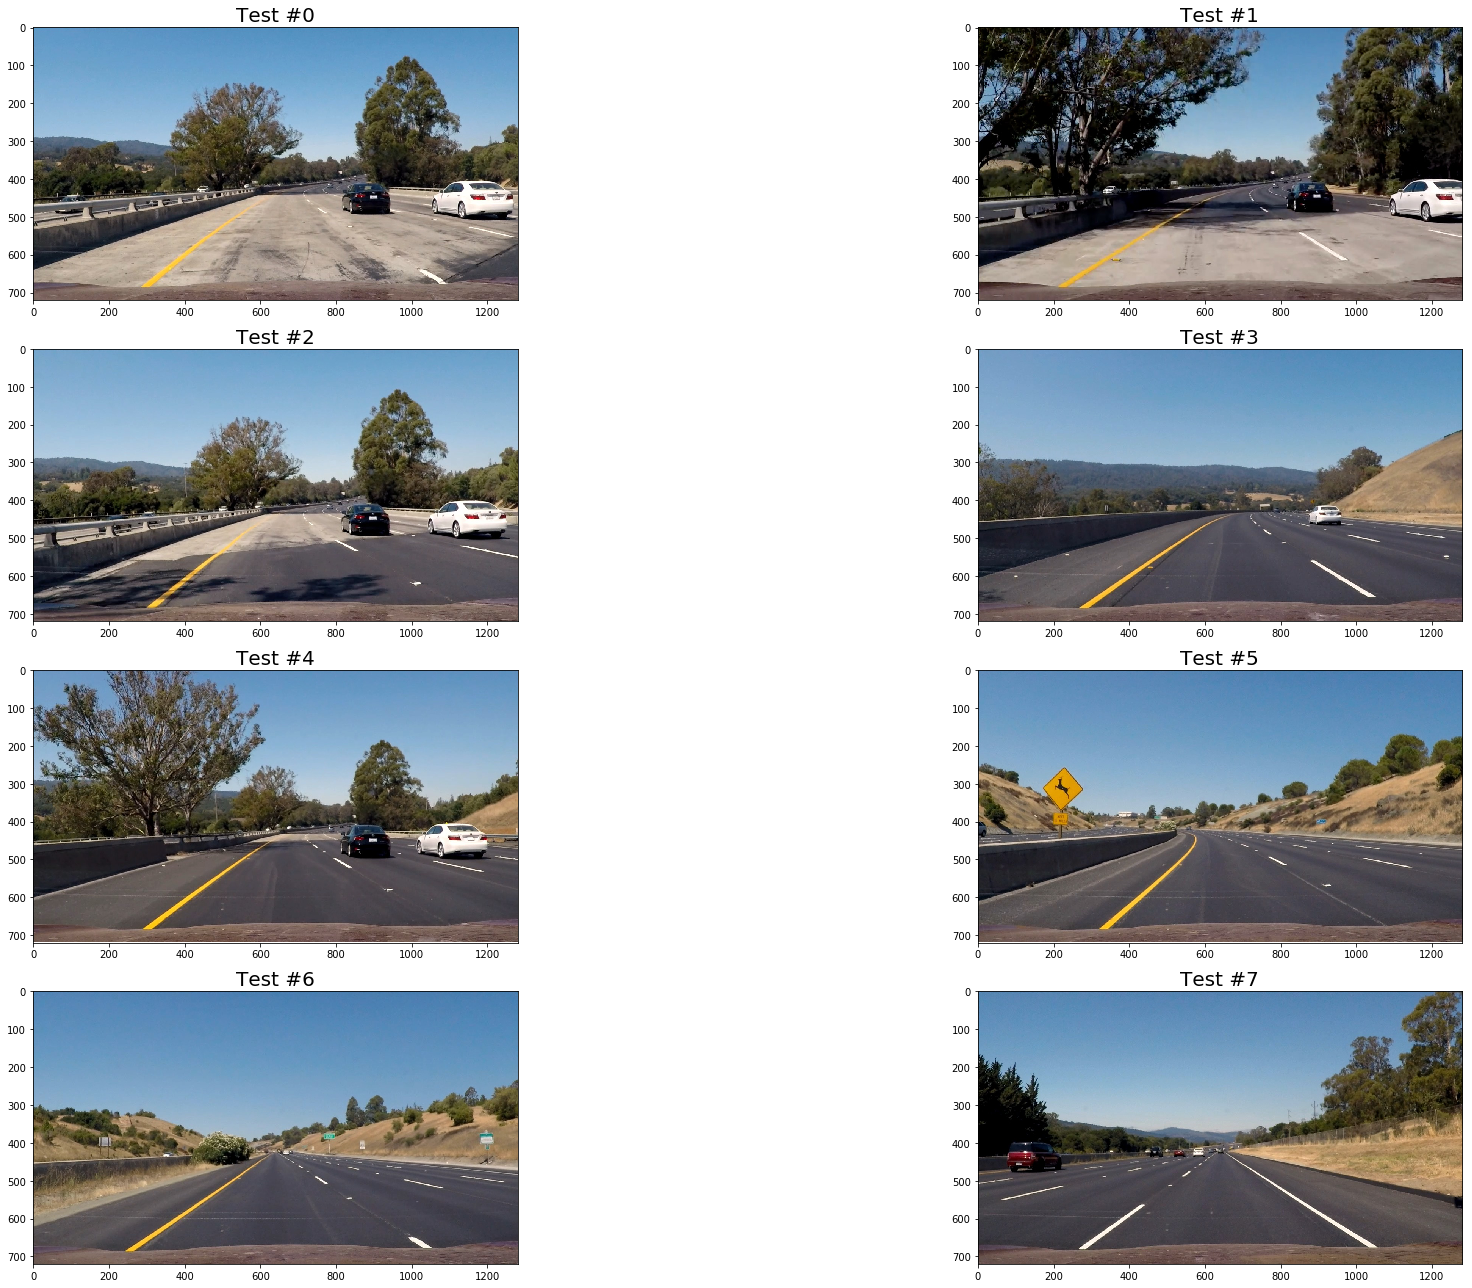

In [3]:
def getTestingImages(pathname):
    files = glob.glob(pathname)
    images = []
    for fname in files:
        img = mpimg.imread(fname)
        images.append(img)
    return images

testImages = getTestingImages('test_images/test*.jpg')  
testImages = testImages+getTestingImages('test_images/straight_lines*.jpg')
testTitles = []
testCmap = []
for i in range(0, len(testImages)):
    testTitles.append("Test #{}".format(i))
    testCmap.append(None)
    
plotMany(4, 2, testImages, testTitles, testCmap)

### Camera Calibration ###
Prior to executing the lane finding pipeline, the camera must be calibrated using 9x6 chessboard images.  This is only completed once.

_Globals and Functions for calibration:_

In [4]:
nx = 9
ny = 6

worldPoints = []
worldPt = np.zeros((nx*ny,3), np.float32)
worldPt[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) 

imagePoints = []

def findChessboardPoints(fname):
    # Find the chessboard corners of file.
    iRGB = mpimg.imread(fname)
    
    # Search for the image chessboard points
    gray = cv2.cvtColor(iRGB, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # Store the points if found
    if ret == True:
        worldPoints.append(worldPt)
        imagePoints.append(corners)
        iRGB = cv2.drawChessboardCorners(iRGB, (nx,ny), corners, ret)
    return iRGB

_Testing/Plotting Cell:_

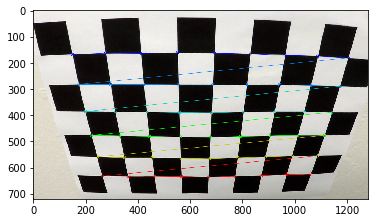

In [5]:
iRGB = findChessboardPoints('camera_cal/calibration2.jpg')
plt.imshow(iRGB)

Process all the provided calibration images and run the calibration.

In [6]:
images = glob.glob('camera_cal/calibration*.jpg')
for chessboard in images:
    findChessboardPoints(chessboard)

print("Calibration points found in {} of {} images".
      format(len(imagePoints), len(images)))

ret, cameraMtx, distCoeffs, rotVecs, transVecs = cv2.calibrateCamera(
    worldPoints, imagePoints, iRGB.shape[0:2], None, None)

Calibration points found in 18 of 20 images


### Lane Finding Pipeline ###
1. Distortion correction
2. Binary image threshold creation
3. Perspective transformation
4. Lane line identification
5. Curvature and location estimation

#### Distortion Correction ####
_Functions for undistortion:_

In [7]:
def undistortImage(img):
    # Undistort the image by refining the camera matrix,
    # running the function, then cropping to the region of interest
    h,w = img.shape[:2]
    newMtx, roi = cv2.getOptimalNewCameraMatrix(cameraMtx, distCoeffs,
                                                (w,h), 1, (w,h))
    undist = cv2.undistort(img, cameraMtx, distCoeffs, None, newMtx)
    x,y,w,h = roi
    return undist[y:y+h, x:x+w]

_Testing/Plotting Cell:_

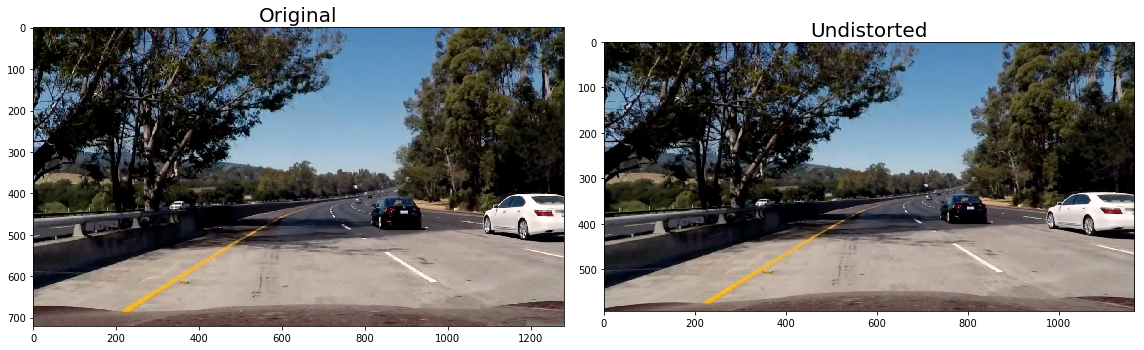

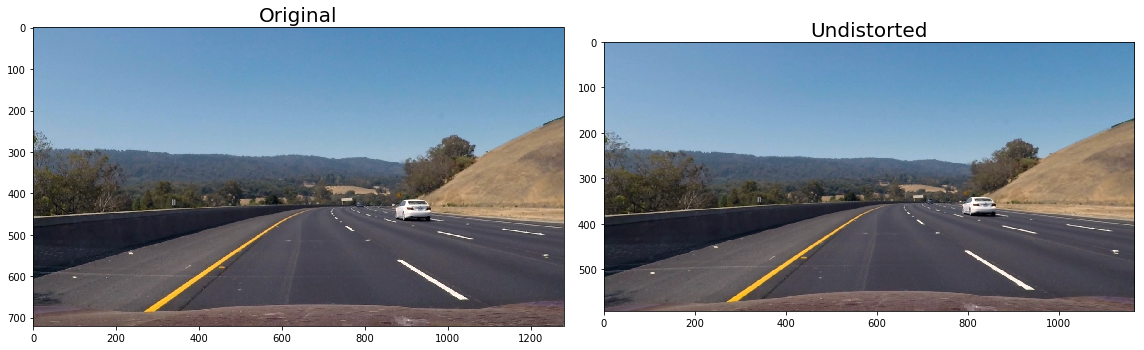

In [13]:
testUndistorteds = []
for img in testImages:
    testUndistorteds.append(undistortImage(img))

samples = random.sample(testImages, 2)
plotTwo(samples[0], undistortImage(samples[0]),
        'Original', 'Undistorted')
plotTwo(samples[1], undistortImage(samples[1]),
        'Original', 'Undistorted')

#### Binary Image Threshold Creation ####
_Functions to create filtered binary images:_  

In [10]:
# ThresholdTesting.ipynb used to determine the following:
SobelKSize = 9
SobelThresh = (50,255)
SobelThreshDir = (0.5, 1.2)
SaturationThresh = (170,255)

def applyThreshold(binary, thresh):
    # Apply the threshold
    binary_th = np.zeros_like(binary)
    binary_th[(binary >= thresh[0]) & (binary <= thresh[1])] = 1
    return binary_th

def applyThresholdSobelAbs(img, orient, sobel_kernel, thresh):
    # Calculate the directional gradient
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    return applyThreshold(scaled_sobel, thresh)

def applyThresholdSobelMag(img, sobel_kernel, thresh):
    # Calculate gradient magnitude
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelxy = np.sqrt(np.square(sobelx) + np.square(sobely))
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    return applyThreshold(scaled_sobel, thresh)

def applyThresholdSobelDir(img, sobel_kernel, thresh):
    # Calculate gradient direction
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.sqrt(np.square(sobelx))
    abs_sobely = np.sqrt(np.square(sobely))
    dir_sobel = np.arctan2(abs_sobely, abs_sobelx)
    return applyThreshold(dir_sobel, thresh)

def applyThresholdSaturation(img, thresh):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    return applyThreshold(s_channel, thresh)

def applyAllThresholds(img):
    # Apply all possible thresholds
    gradx = applyThresholdSobelAbs(img, 'x', SobelKSize, SobelThresh)
    grady = applyThresholdSobelAbs(img, 'y', SobelKSize, SobelThresh)
    magB = applyThresholdSobelMag(img, SobelKSize, SobelThresh)
    dirB = applyThresholdSobelDir(img, SobelKSize, SobelThreshDir)
    satB = applyThresholdSaturation(img, SaturationThresh)
    return gradx, grady, magB, dirB, satB   

def combineThresholds(img):
    # Combine thresholds for pipeline use
    magB = applyThresholdSobelMag(img, SobelKSize, SobelThresh)
    dirB = applyThresholdSobelDir(img, SobelKSize, SobelThreshDir)
    magDirB = np.zeros_like(dirB)
    magDirB[((magB == 1) & (dirB == 1))] = 1
    
    satB = applyThresholdSaturation(img, SaturationThresh)
    combined = np.zeros_like(satB)
    combined[(satB == 1) | (magDirB == 1)] = 1 
    return magDirB, satB, combined 

_Testing/Plotting Cells:_

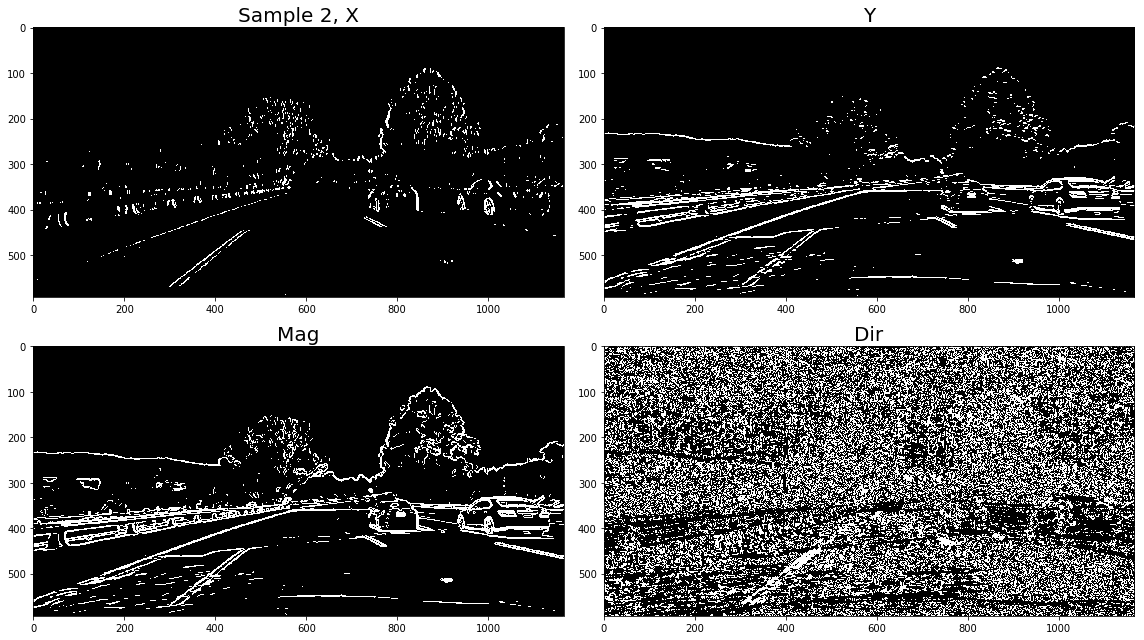

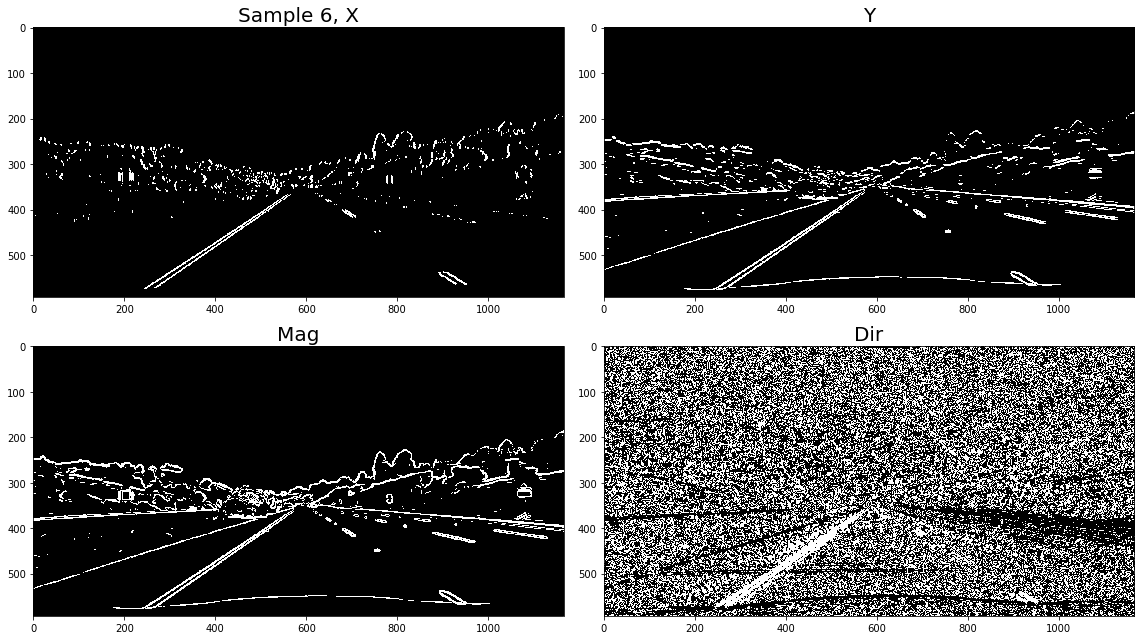

In [14]:
samples = random.sample(range(0,len(testUndistorteds)), 2)
grayMaps = ['gray','gray','gray','gray']

for idx, img in enumerate(testUndistorteds):
    # Run all the threshold calculations
    gradx, grady, magB, dirB, satB = applyAllThresholds(img)
    
    if idx in samples:
        plotMany(2, 2, [gradx,grady,magB,dirB],
                ["Sample {}, X".format(idx),'Y','Mag','Dir'],
                 grayMaps)

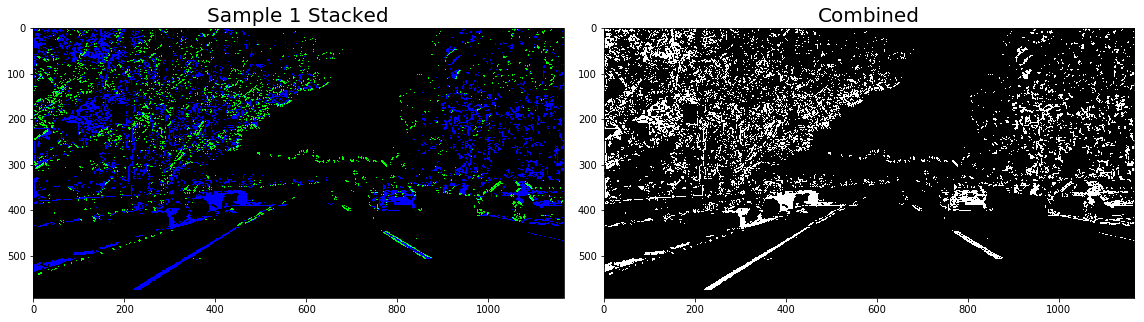

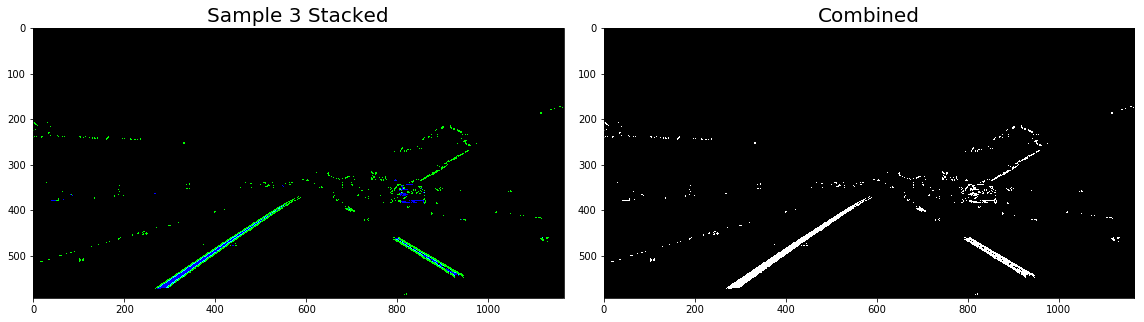

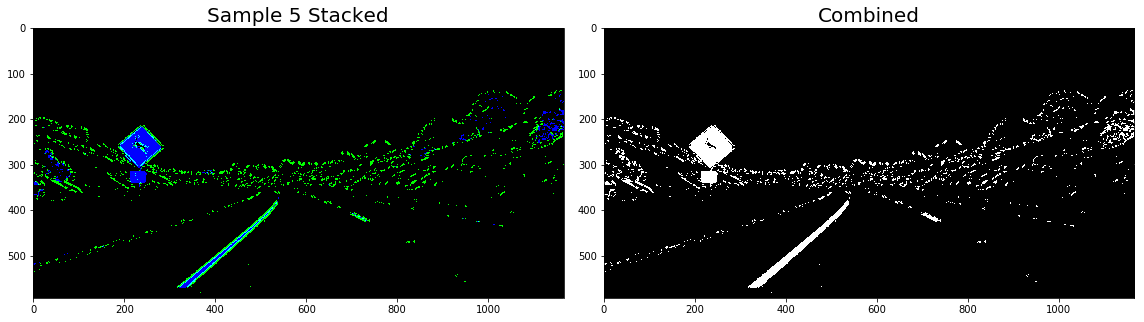

In [15]:
testCombined = []
samples = random.sample(range(0,len(testUndistorteds)), 3)

for idx, img in enumerate(testUndistorteds):
    # Create the combined threshold
    magDirB, satB, combined = combineThresholds(img)
    testCombined.append(combined)
    
    if idx in samples:
        plotStacked(magDirB, satB, combined, 
                    "Sample {} Stacked".format(idx), "Combined")

#### Perspective Transformation ####
First testing to determing the trapezoidal shape to use for the transform

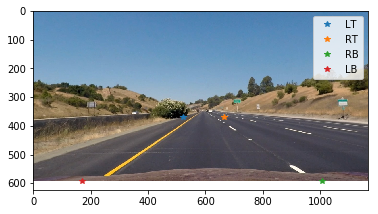

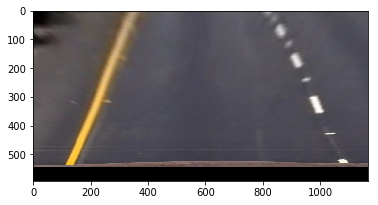

In [59]:
iStraight = testUndistorteds[6]
plt.imshow(iStraight)

img_size = (iStraight.shape[1], iStraight.shape[0])
top = img_size[1]/2 + 3*PIXEL_PER_M_y
center = img_size[0]/2

left_top = (center - 60, top)
right_top = (center + 80, top)
right_bottom = (img_size[0]- PIXEL_PER_M_x + 30, img_size[1])
left_bottom = (PIXEL_PER_M_x - 20, img_size[1])

plt.plot(left_top[0], left_top[1], '*', label='LT')
plt.plot(right_top[0], right_top[1], '*', label='RT')
plt.plot(right_bottom[0], right_bottom[1], '*', label='RB')
plt.plot(left_bottom[0], left_bottom[1], '*', label='LB')
plt.legend()
plt.show()
    
offset = 50
src = np.float32([left_top, right_top, right_bottom, left_bottom])
dst = np.float32([[offset, offset], #L top
                 [img_size[0]-offset, offset], #R top
                 [img_size[0]-offset, img_size[1]-offset], #R bottom 
                 [offset, img_size[1]-offset] #L bottom
                 ])

M = cv2.getPerspectiveTransform(src, dst)
plt.imshow(cv2.warpPerspective(iStraight, M, img_size))

_Functions to transform the perspective of the image:_ 

In [55]:
def warpToBirdsEye(img):
    # Perform a perspective transform for the region of interest
    img_size = (img.shape[1], img.shape[0])   
    
    center = img_size[0]/2
    src = np.float32([left_top, right_top, right_bottom, left_bottom])
    
    offset = 50
    dst = np.float32([[offset, offset], #L top
                      [img_size[0]-offset, offset], #R top
                      [img_size[0]-offset, img_size[1]-offset], #R bottom 
                      [offset, img_size[1]-offset] #L bottom
                     ])
    M = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(img, M, img_size)

_Testing/Plotting Cell:_

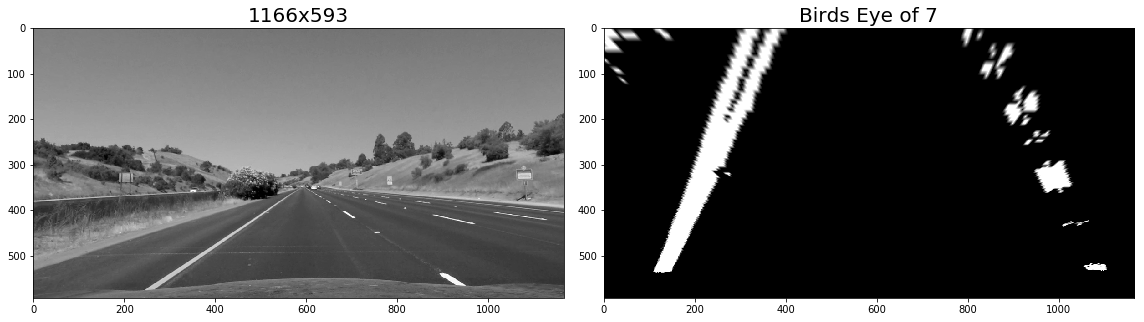

In [56]:
orig = cv2.cvtColor(testUndistorteds[6],cv2.COLOR_RGB2GRAY)
    
warped = warpToBirdsEye(testCombined[6])
    
plotTwo(orig, warped, "{}x{}".format(img.shape[1],img.shape[0]),
        "Birds Eye of {}".format(idx), 'gray', 'gray')

In [ ]:
testBirdsEye = []
samples = random.sample(range(0,len(testCombined)), 3)


for idx, img in enumerate(testCombined):
    # Perform the perspective
    warped = warpToBirdsEye(img)
    testBirdsEye.append(warped)
    
    if idx in samples:
        plotTwo(warped, img, "Birds Eye of {}".format(idx), 
                "{}x{}".format(img.shape[1],img.shape[0]), 
                'gray', 'gray')

#### Lane Line Identification ####

#### Curvature and Location Estimation ####